
[Open in Colab](https://colab.research.google.com/drive/1sG4VUDZ80WdLo6ah9gjyXtWounrosG10?usp=sharing)


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading Data Set

In [3]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Analysing The Data Structure

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# ocean_proximity Values

In [8]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


# Create a Test Set

In [9]:
np.random.seed(42)

In [10]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [17]:
housing["income_cat"].value_counts() / len(housing)

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Prepareing the Data

## Data Cleaning

In [20]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [21]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN




```
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2
```



In [22]:
#we use option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

<ipython-input-22-4c2ca6b8c910>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute

In [24]:
housing_num = housing.drop("ocean_proximity", axis=1)


In [25]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [26]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [27]:
housing_num.median().values #Check that this is the same as manually computing the median of each attribute:

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

## Transform the training set:

In [28]:
X = imputer.transform(housing_num)

In [29]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [30]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [32]:
imputer.strategy

'median'

In [31]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [33]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handling Text and Categorical Attributes

### Preprocess the categorical input feature, ocean_proximity:

In [34]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [35]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [36]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [39]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Transformation Pipelines for Preprocessing the Numerical Attributes:

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),

        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [41]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [42]:
#Full pipeline combining numerical and categorical features

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),  # Apply numerical transformations
        ("cat", OneHotEncoder(), cat_attribs), # Apply OneHotEncoder to categorical feature
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [43]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [44]:
housing_prepared.shape

(16512, 13)

In [45]:


def display_scores(scores): # define the function display_scores
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())



# Model 1 Training: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841]


In [ ]:
print("Labels:", list(some_labels))  #compare with actual values

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


### Root Mean Squared Error: Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.56219504567

### Mean Absolute Error: Linear Regression

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49905.329442715316

### Cross Validation: Linear Regression

In [ ]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494763
Standard deviation: 2372.070791055922


In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,69204.322755
std,2500.382157
min,65318.224029
25%,67124.346106
50%,69404.658178
75%,70697.800632
max,73003.752739


# Model 2 Training: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

### Root Mean Squared Error: Random Forest Regressor

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18342.366362322846

### Mean Absolute Error: Random Forest Regressor

In [ ]:
from sklearn.metrics import mean_absolute_error

forest_mae = mean_absolute_error(housing_labels, housing_predictions)
forest_mae

11813.920286458333

### Cross Validation: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18342.366362322846

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51039.08053738 48741.94041426 45940.42771745 50501.41453432
 47387.7896427  49595.25845731 51625.68567717 48865.70709952
 47322.87631489 53301.08748462]
Mean: 49432.12678796127
Standard deviation: 2124.8587921578355


In [ ]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,49432.126788
std,2239.797830
min,45940.427717
25%,47726.327336
50%,49230.482778
75%,50904.664037
max,53301.087485


# Model 3 Training: Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

### Root Mean Squared Error: Decision Tree Regressor

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Mean Absolute Error: Decision Tree Regressor

In [ ]:
from sklearn.metrics import mean_absolute_error

tree_mae = mean_absolute_error(housing_labels, housing_predictions)
tree_mae

0.0

### Cross Validation: Decision Tree Regressor

In [ ]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard deviation: 2296.288087393378


In [ ]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,69081.361563
std,2420.500173
min,64770.563939
25%,67525.053996
50%,69027.994020
75%,70675.556581
max,73280.387324


# Model 4 Training: Support Vector Machine Regressor (SVR)

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

SVR(kernel='linear')

### Root Mean Squared Error: SVR

In [ ]:
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111802.67909771342

### Mean Absolute Error: SVR

In [ ]:
from sklearn.metrics import mean_absolute_error

svm_mae = mean_absolute_error(housing_labels, housing_predictions)
svm_mae

82276.56523050081

### Cross Validation: SVR

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [111059.94607445 113687.87132915 107597.3277054  114213.41574463
 108461.30158859 116616.25904798 113850.21483718 112395.74942581
 113807.23691329 112686.31474177]
Mean: 112437.56374082548
Standard deviation: 2593.2605559090666


In [ ]:
scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,112437.563741
std,2733.536641
min,107597.327705
25%,111393.896912
50%,113187.093035
75%,113839.470356
max,116616.259048


###########################################################

## RMSE Comparison Plot:

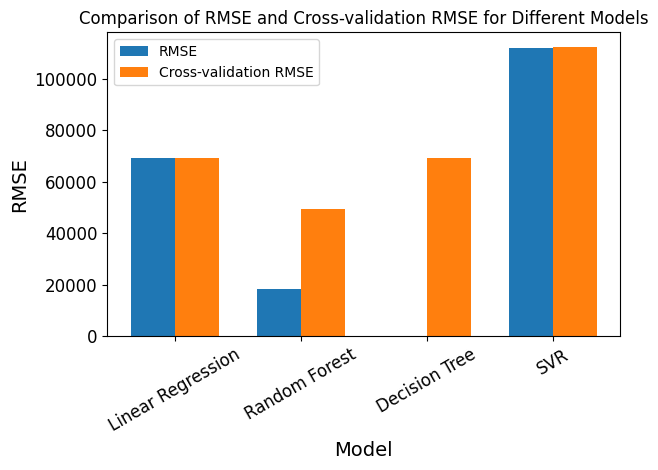

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Linear Regression', 'Random Forest', 'Decision Tree', 'SVR']
rmse = [69050.56, 18342.37, 0, 111802.68]
cv_rmse = [69204.32, 49432.13, 69081.36, 112437.56]

# Plot RMSE and Cross-validation RMSE
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, rmse, bar_width, label='RMSE')
plt.bar(index + bar_width, cv_rmse, bar_width, label='Cross-validation RMSE')

# Labels and titles
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE and Cross-validation RMSE for Different Models')
plt.xticks(index + bar_width / 2, models, rotation=30)
plt.legend()

plt.tight_layout()
plt.show()


# SVR with with various hyperparameters

Experimenting SVR (sklearn.svm.SVR) with `kernel="linear"` and `kernel="rbf"` hyperparameters




In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=  11.6s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.6s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.3s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.0s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.5s
[CV] END .............................C=100.0, kernel=linear; total time=  10.6s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70444.58358729436

In [ ]:
grid_search.best_params_  #check the best hyperparameters found:

{'C': 30000.0, 'kernel': 'linear'}

# Model Fine-Tune

## Random Forest

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor # import the RandomForestRegressor


param_grid = {
    'n_estimators': [3, 10, 30],                  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],        # Number of features to consider when looking for the best split
    #'max_depth': [None, 10, 20, 30],                 # Maximum depth of the tree
    #'min_samples_split': [2, 5, 10],                 # Minimum number of samples required to split a node
    #'min_samples_leaf': [1, 2, 4],                   # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                      # Whether bootstrap samples are used
}
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=30,
                      random_state=42)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 3}
nan {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 10}
nan {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 30}
62171.74914682597 {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 3}
54710.23310787722 {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 10}
51531.790344295514 {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 30}
62171.74914682597 {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 3}
54710.23310787722 {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 10}
51531.790344295514 {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 30}
nan {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 3}
nan {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 10}
nan {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 30}
59026.17902108823 {'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 3}
52996.55803561763

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002252,0.000753,0.000000,0.000000,True,auto,3,"{'bootstrap': True, 'max_features': 'auto', 'n...",NaN,NaN,...,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001456,0.000243,0.000000,0.000000,True,auto,10,"{'bootstrap': True, 'max_features': 'auto', 'n...",NaN,NaN,...,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001259,0.000172,0.000000,0.000000,True,auto,30,"{'bootstrap': True, 'max_features': 'auto', 'n...",NaN,NaN,...,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.116265,0.002939,0.005345,0.000355,True,sqrt,3,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",-3.732142e+09,-3.653254e+09,...,-3.865326e+09,1.527890e+08,11,-1.016700e+09,-1.046461e+09,-1.045885e+09,-1.045423e+09,-1.045532e+09,-1.040000e+09,1.165567e+07
4,0.377488,0.004118,0.013344,0.000913,True,sqrt,10,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",-2.914560e+09,-2.900460e+09,...,-2.993210e+09,9.141260e+07,7,-5.587919e+08,-5.837848e+08,-5.514535e+08,-5.597968e+08,-5.765104e+08,-5.660675e+08,1.207295e+07
5,1.181877,0.110463,0.037230,0.001683,True,sqrt,30,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",-2.652932e+09,-2.508006e+09,...,-2.655525e+09,9.581937e+07,3,-4.118554e+08,-4.130594e+08,-4.110544e+08,-3.960956e+08,-4.156371e+08,-4.095404e+08,6.898810e+06
6,0.159594,0.003352,0.006386,0.000345,True,log2,3,"{'bootstrap': True, 'max_features': 'log2', 'n...",-3.732142e+09,-3.653254e+09,...,-3.865326e+09,1.527890e+08,11,-1.016700e+09,-1.046461e+09,-1.045885e+09,-1.045423e+09,-1.045532e+09,-1.040000e+09,1.165567e+07
7,0.454680,0.073765,0.014865,0.000986,True,log2,10,"{'bootstrap': True, 'max_features': 'log2', 'n...",-2.914560e+09,-2.900460e+09,...,-2.993210e+09,9.141260e+07,7,-5.587919e+08,-5.837848e+08,-5.514535e+08,-5.597968e+08,-5.765104e+08,-5.660675e+08,1.207295e+07
8,1.115089,0.002989,0.036742,0.001099,True,log2,30,"{'bootstrap': True, 'max_features': 'log2', 'n...",-2.652932e+09,-2.508006e+09,...,-2.655525e+09,9.581937e+07,3,-4.118554e+08,-4.130594e+08,-4.110544e+08,-3.960956e+08,-4.156371e+08,-4.095404e+08,6.898810e+06
9,0.001303,0.000141,0.000000,0.000000,False,auto,3,"{'bootstrap': False, 'max_features': 'auto', '...",NaN,NaN,...,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Randomized Search

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {

        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),              # Minimum number of samples required to be at a leaf node
        'bootstrap': [True, False]
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b1143b96d10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b114477eb00>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'n_estimators': 3, 'max_features': 'auto', 'bootstrap': True}
nan {'n_estimators': 10, 'max_features': 'auto', 'bootstrap': True}
51531.790344295514 {'n_estimators': 30, 'max_features': 'log2', 'bootstrap': True}
51531.790344295514 {'n_estimators': 30, 'max_features': 'sqrt', 'bootstrap': True}
62171.74914682597 {'n_estimators': 3, 'max_features': 'sqrt', 'bootstrap': True}
52996.55803561763 {'n_estimators': 10, 'max_features': 'sqrt', 'bootstrap': False}
52996.55803561763 {'n_estimators': 10, 'max_features': 'log2', 'bootstrap': False}
59026.17902108823 {'n_estimators': 3, 'max_features': 'log2', 'bootstrap': False}
nan {'n_estimators': 30, 'max_features': 'auto', 'bootstrap': False}
nan {'n_estimators': 30, 'max_features': 'auto', 'bootstrap': True}


In [ ]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

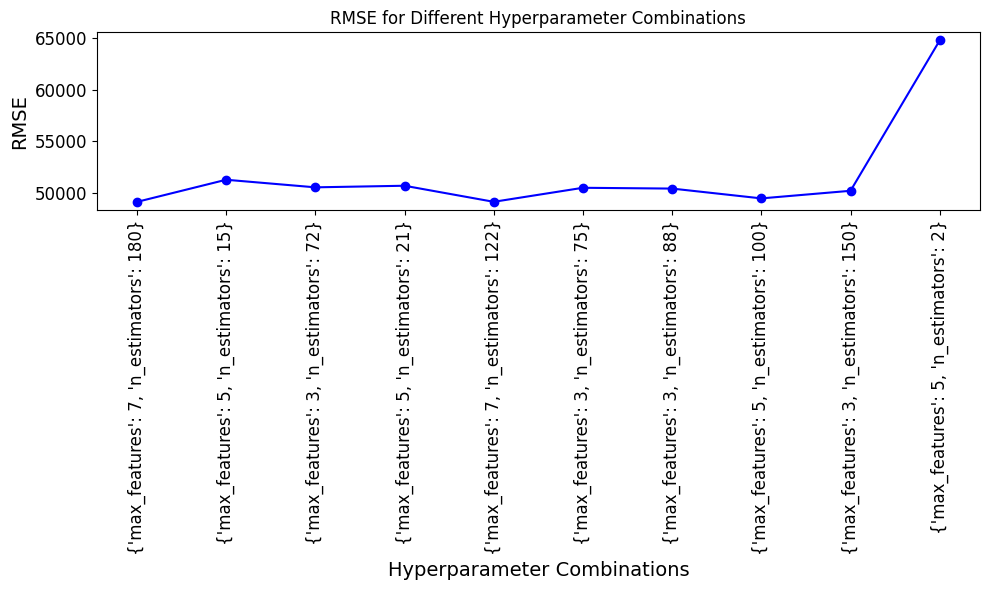

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the RMSE values and hyperparameters
cvres = rnd_search.cv_results_
rmse_values = [np.sqrt(-mean_score) for mean_score in cvres["mean_test_score"]]
params = [str(params) for params in cvres["params"]]

# Plot the RMSE values
plt.figure(figsize=(10, 6))
plt.plot(rmse_values, marker='o', linestyle='-', color='b')

# Set x-ticks as hyperparameter combinations (make it less cluttered)
plt.xticks(ticks=range(len(params)), labels=params, rotation=90)

# Add labels and title
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('RMSE')
plt.title('RMSE for Different Hyperparameter Combinations')

# Show the plot with tight layout
plt.tight_layout()
plt.show()


In [ ]:
pd.DataFrame(rnd_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.057701,0.095141,0.202668,0.001985,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.417970e+09,-2.285911e+09,-2.342062e+09,-2.498930e+09,-2.519735e+09,-2.412922e+09,8.942591e+07,1
1,1.009133,0.135988,0.020917,0.001723,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.644489e+09,-2.541174e+09,-2.606342e+09,-2.682713e+09,-2.669420e+09,-2.628828e+09,5.096149e+07,9
2,2.846255,0.260408,0.087537,0.010366,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.572120e+09,-2.384048e+09,-2.504377e+09,-2.646321e+09,-2.662253e+09,-2.553824e+09,1.018982e+08,7
3,1.127742,0.006211,0.025358,0.000840,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.569152e+09,-2.456736e+09,-2.531507e+09,-2.655395e+09,-2.634575e+09,-2.569473e+09,7.179402e+07,8
4,9.627937,0.406520,0.138197,0.001419,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.417756e+09,-2.284938e+09,-2.344903e+09,-2.501723e+09,-2.519256e+09,-2.413715e+09,8.968737e+07,2
5,2.939177,0.227179,0.092425,0.013182,3,75,"{'max_features': 3, 'n_estimators': 75}",-2.566363e+09,-2.386037e+09,-2.492440e+09,-2.645017e+09,-2.657286e+09,-2.549429e+09,1.009966e+08,6
6,3.426380,0.247526,0.104074,0.006824,3,88,"{'max_features': 3, 'n_estimators': 88}",-2.565486e+09,-2.386438e+09,-2.483266e+09,-2.636766e+09,-2.636188e+09,-2.541629e+09,9.597109e+07,5
7,6.013199,0.463237,0.116153,0.009066,5,100,"{'max_features': 5, 'n_estimators': 100}",-2.472576e+09,-2.316522e+09,-2.371355e+09,-2.531208e+09,-2.540787e+09,-2.446490e+09,8.864115e+07,3
8,6.267479,0.640483,0.206912,0.048722,3,150,"{'max_features': 3, 'n_estimators': 150}",-2.547128e+09,-2.372713e+09,-2.449763e+09,-2.617137e+09,-2.613575e+09,-2.520063e+09,9.545109e+07,4
9,0.115808,0.004971,0.004112,0.000063,5,2,"{'max_features': 5, 'n_estimators': 2}",-4.085143e+09,-4.112531e+09,-4.154873e+09,-4.396277e+09,-4.246619e+09,-4.199089e+09,1.127594e+08,10


## Linear Regression





### Grid Search: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

from sklearn.model_selection import GridSearchCV

# Remove max_features and other parameters not applicable to LinearRegression
param_grid = [
    {'n_jobs': [-1, 1, 4]}, # Example of parameters applicable to LinearRegression
    {'fit_intercept': [True, False]}
  ]

grid_search = GridSearchCV(lin_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid=[{'n_jobs': [-1, 1, 4]},
                         {'fit_intercept': [True, False]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'n_jobs': -1}

In [ ]:
grid_search.best_estimator_

LinearRegression(n_jobs=-1)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

69221.88833184607 {'n_jobs': -1}
69221.88833184607 {'n_jobs': 1}
69221.88833184607 {'n_jobs': 4}
69221.88833184607 {'fit_intercept': True}
69311.99974328835 {'fit_intercept': False}


### Randormized Search: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution for Randomized Search for Linear Regression
param_distribs = {
    'n_jobs': [-1, 1, 4],
    'fit_intercept': [True, False],   # Whether to calculate the intercept

}

# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Perform Randomized Search with 5-fold cross-validation
rnd_search = RandomizedSearchCV(lin_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the model with the prepared data
rnd_search.fit(housing_prepared, housing_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LinearRegression(),
                   param_distributions={'fit_intercept': [True, False],
                                        'n_jobs': [-1, 1, 4]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

69221.88833184607 {'n_jobs': -1, 'fit_intercept': True}
69221.88833184607 {'n_jobs': 1, 'fit_intercept': True}
69221.88833184607 {'n_jobs': 4, 'fit_intercept': True}
69311.99974328835 {'n_jobs': -1, 'fit_intercept': False}
69311.99974328835 {'n_jobs': 1, 'fit_intercept': False}
69311.99974328835 {'n_jobs': 4, 'fit_intercept': False}


In [ ]:
rnd_search.best_params_

{'n_jobs': -1, 'fit_intercept': True}

# Decision Tree Regression

### Grid Search: Decision Tree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],               # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                    # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2'],    # Number of features to consider when looking for the best split
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Fit the model with the prepared data
grid_search.fit(housing_prepared, housing_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

70644.07630902066 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
67914.83183823497 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
64792.51124495886 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
66924.16728899184 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
65990.05659333336 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
63227.98130793577 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
62737.729153219654 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
62737.729153219654 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
61837.42552811118 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
nan {'max_depth': None, 'max_fea

### Randormized Search: Decision Tree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Initialize the Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)

# Define the parameter distributions for Randomized Search
param_distribs = {
    'max_depth': [None, 10, 20, 30, 40, 50],               # Maximum depth of the tree
    'min_samples_split': randint(2, 20),                   # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),                    # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2'],        # Number of features to consider when looking for the best split
}

# Perform Randomized Search with 5-fold cross-validation
rnd_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                random_state=42, return_train_score=True)

# Fit the model with the prepared data
rnd_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
65 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7811d956f250>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7811d94ce7a0>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

58414.402235317066 {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 12}
59866.3678401743 {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 12}
70505.2989777575 {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 9}
nan {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 13}
nan {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}
nan {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 18}
71205.97074058135 {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 17}
nan {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 13}
71936.16420171468 {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 6}
68958.95802089633 {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_

# Support Vector Machine Regression

### Grid Search: SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Initialize the SVR model
svr_reg = SVR()

# Define the parameter grid for Grid Search
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
    #'kernel': ['linear', 'rbf'],              # Kernel type: 'linear' or 'rbf' (Radial Basis Function)
   # 'C': [0.1, 1, 10, 100],                   # Regularization parameter
   # 'epsilon': [0.01, 0.1, 0.2, 0.5, 1],      # Epsilon in the epsilon-SVR model (margin of tolerance)
   # 'gamma': ['scale', 'auto']                # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'


# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svr_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Fit the model with the prepared data
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70444.58358729436

In [ ]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

84616.02428592577 {'C': 10.0, 'kernel': 'linear'}
75758.35494125567 {'C': 30.0, 'kernel': 'linear'}
72031.56620357497 {'C': 100.0, 'kernel': 'linear'}
70878.55936643491 {'C': 300.0, 'kernel': 'linear'}
70551.98140425506 {'C': 1000.0, 'kernel': 'linear'}
70473.66916082146 {'C': 3000.0, 'kernel': 'linear'}
70451.25742476787 {'C': 10000.0, 'kernel': 'linear'}
70444.58358729436 {'C': 30000.0, 'kernel': 'linear'}
118830.53589832103 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
118720.88453353591 {'C': 1.0, 'gamma': 0.03, 'kernel': 'rbf'}
118636.62856387992 {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
118740.49635813803 {'C': 1.0, 'gamma': 0.3, 'kernel': 'rbf'}
118879.41106810993 {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
118926.73572256803 {'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}
118636.10934181797 {'C': 3.0, 'gamma': 0.01, 'kernel': 'rbf'}
118302.6179777409 {'C': 3.0, 'gamma': 0.03, 'kernel': 'rbf'}
118064.17390458037 {'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}
118361.07662114831 {'C': 3.0, 'gamma

### Randormized Search: SVR

In [46]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Initialize the SVR model
svr_reg = SVR()

# Define the parameter distributions for Randomized Search
param_distribs = {
    'C':  [10., 30., 100., 300., 1000., 3000., 10000., 30000.0],                  # Regularization parameter (sampled from uniform distribution)

    'kernel': ['linear', 'rbf'],             # Kernel type: 'linear' or 'rbf' (Radial Basis Function)
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],              # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Perform Randomized Search with 5-fold cross-validation
rnd_search = RandomizedSearchCV(svr_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                random_state=42, return_train_score=True)

# Fit the model with the prepared data
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': [10.0, 30.0, 100.0, 300.0, 1000.0,
                                              3000.0, 10000.0, 30000.0],
                                        'gamma': [0.01, 0.03, 0.1, 0.3, 1.0,
                                                  3.0],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [49]:
rnd_search.best_params_

{'kernel': 'rbf', 'gamma': 0.3, 'C': 30000.0}

In [48]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

70451.25742476787 {'kernel': 'linear', 'gamma': 1.0, 'C': 10000.0}
61508.22193746481 {'kernel': 'rbf', 'gamma': 0.1, 'C': 10000.0}
68887.3591230628 {'kernel': 'rbf', 'gamma': 0.01, 'C': 10000.0}
70444.58358729436 {'kernel': 'linear', 'gamma': 3.0, 'C': 30000.0}
114376.7999657043 {'kernel': 'rbf', 'gamma': 1.0, 'C': 100.0}
60592.55816107109 {'kernel': 'rbf', 'gamma': 0.3, 'C': 10000.0}
84032.29104979085 {'kernel': 'rbf', 'gamma': 1.0, 'C': 3000.0}
70878.55936643491 {'kernel': 'linear', 'gamma': 0.3, 'C': 300.0}
84616.02428592577 {'kernel': 'linear', 'gamma': 0.01, 'C': 10.0}
84616.02428592577 {'kernel': 'linear', 'gamma': 3.0, 'C': 10.0}
70473.66916082146 {'kernel': 'linear', 'gamma': 0.1, 'C': 3000.0}
72031.56620357497 {'kernel': 'linear', 'gamma': 0.3, 'C': 100.0}
75758.35494125567 {'kernel': 'linear', 'gamma': 0.3, 'C': 30.0}
84616.02428592577 {'kernel': 'linear', 'gamma': 0.1, 'C': 10.0}
104604.43935737801 {'kernel': 'rbf', 'gamma': 0.3, 'C': 100.0}
72031.56620357497 {'kernel': 'lin

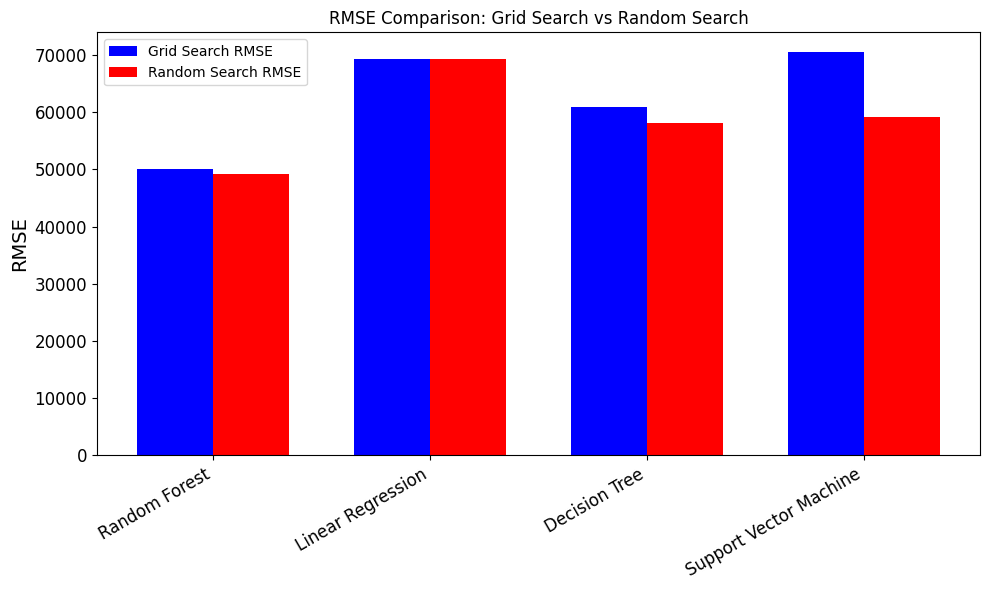

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the RMSE values
models = ['Random Forest', 'Linear Regression', 'Decision Tree', 'Support Vector Machine']
grid_rmse = [50127.59, 69221.89, 60920.56, 70444.58]
random_rmse = [49203.14, 69221.89, 58053.78, 59232.88]

# Plotting
x = np.arange(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Grid Search and Random Search
bar1 = ax.bar(x - width/2, grid_rmse, width, label='Grid Search RMSE', color='b')
bar2 = ax.bar(x + width/2, random_rmse, width, label='Random Search RMSE', color='r')

# Labels and Titles
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: Grid Search vs Random Search')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


# Evaluate Final System With Test Set

Selecting Random Forest, Random Search hyperparameters as the best parameters

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {

        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),              # Minimum number of samples required to be at a leaf node
        'bootstrap': [True, False]
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search_best = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_best.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ed00acac700>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ed00ac8c640>},
                   random_state=42, scoring='neg_mean_squared_error')

In [56]:
from sklearn.metrics import mean_squared_error
final_model = rnd_search_best.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [57]:
final_rmse

46718.090616335794